# Feature Engineering and Exploratory Data Analysis of Processed Data

---

This notebook explores the spatially joined Nightfire data with the Basin data and generates and explores the features to be used for modeling in the following notebook. Please note that the plots in this notebook are not explicitly for presentation but for quickly exploring the intermediate data. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Engineering-and-Exploratory-Data-Analysis-of-Processed-Data" data-toc-modified-id="Feature-Engineering-and-Exploratory-Data-Analysis-of-Processed-Data-1">Feature Engineering and Exploratory Data Analysis of Processed Data</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1">Imports</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis---Processed-Data" data-toc-modified-id="Exploratory-Data-Analysis---Processed-Data-2">Exploratory Data Analysis - Processed Data</a></span><ul class="toc-item"><li><span><a href="#Explore-Missing-Data-in-Post-Geoprocessed-Nightfire-spatially-joined-with-Basin-data." data-toc-modified-id="Explore-Missing-Data-in-Post-Geoprocessed-Nightfire-spatially-joined-with-Basin-data.-2.1">Explore Missing Data in Post-Geoprocessed Nightfire spatially joined with Basin data.</a></span></li><li><span><a href="#Aggregate-data-for-Region-by-Day" data-toc-modified-id="Aggregate-data-for-Region-by-Day-2.2">Aggregate data for Region by Day</a></span></li><li><span><a href="#Explore-Aggregated-data-for-Region-by-Day" data-toc-modified-id="Explore-Aggregated-data-for-Region-by-Day-2.3">Explore Aggregated data for Region by Day</a></span><ul class="toc-item"><li><span><a href="#Keep-obs_day_cnt,-looks-reliable." data-toc-modified-id="Keep-obs_day_cnt,-looks-reliable.-2.3.1">Keep <code>obs_day_cnt</code>, looks reliable.</a></span></li><li><span><a href="#Drop-qf_detect" data-toc-modified-id="Drop-qf_detect-2.3.2">Drop <code>qf_detect</code></a></span></li><li><span><a href="#Keep-qf_fit" data-toc-modified-id="Keep-qf_fit-2.3.3">Keep <code>qf_fit</code></a></span></li></ul></li><li><span><a href="#Create-Monthly-Aggregation-Decriptive-Statistics-of-Daily-variables" data-toc-modified-id="Create-Monthly-Aggregation-Decriptive-Statistics-of-Daily-variables-2.4">Create Monthly Aggregation Decriptive Statistics of Daily variables</a></span></li><li><span><a href="#Explore-Monthly-Aggregation-Decriptive-Statistics-of-Daily-variables" data-toc-modified-id="Explore-Monthly-Aggregation-Decriptive-Statistics-of-Daily-variables-2.5">Explore Monthly Aggregation Decriptive Statistics of Daily variables</a></span><ul class="toc-item"><li><span><a href="#Merge-the-Target-variable-from-Energy-Information-Administration-oil_bbl_d_total_production" data-toc-modified-id="Merge-the-Target-variable-from-Energy-Information-Administration-oil_bbl_d_total_production-2.5.1">Merge the Target variable from Energy Information Administration <code>oil_bbl_d_total_production</code></a></span></li><li><span><a href="#Create-time-dependent-variables,-such-as-percent-of-month-completed" data-toc-modified-id="Create-time-dependent-variables,-such-as-percent-of-month-completed-2.5.2">Create time dependent variables, such as percent of month completed</a></span></li></ul></li><li><span><a href="#Generate-modeling-dataset" data-toc-modified-id="Generate-modeling-dataset-2.6">Generate modeling dataset</a></span><ul class="toc-item"><li><span><a href="#Review-and-sanity-check-a-couple-variables" data-toc-modified-id="Review-and-sanity-check-a-couple-variables-2.6.1">Review and sanity check a couple variables</a></span></li></ul></li></ul></li><li><span><a href="#Create-Time-Map-Animation-of-Nightfire-data-in-Region" data-toc-modified-id="Create-Time-Map-Animation-of-Nightfire-data-in-Region-3">Create Time Map Animation of Nightfire data in Region</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#A-Year-(2017)-of-Nightfire-data---Bakken-Region" data-toc-modified-id="A-Year-(2017)-of-Nightfire-data---Bakken-Region-3.0.1">A Year (2017) of Nightfire data - Bakken Region</a></span><ul class="toc-item"><li><span><a href="#Below-cell-code-generates-365-images-for-automated-gif-animation.-No-need-to-scroll.-Go-to:" data-toc-modified-id="Below-cell-code-generates-365-images-for-automated-gif-animation.-No-need-to-scroll.-Go-to:-3.0.1.1">Below cell <code>code</code> generates 365 images for automated-gif animation. No need to scroll. Go to:</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Next-Notebook" data-toc-modified-id="Next-Notebook-4">Next Notebook</a></span></li></ul></div>

## Imports

In [80]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
import glob
import geopandas as gpd
import pandas as pd
import seaborn as sns
import missingno as msno
from shapely import wkt
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio
import warnings
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import MonthBegin


warnings.filterwarnings("ignore")

In [82]:
from tools.tools import read_json, get_current_time
from capstone.etl.viirs_join_basins import viirs_join_basins, compile_basin_data
from capstone.etl.census_parse import parse_census
from capstone.etl.census_retrieval import census_retrieval
from capstone.etl.generate_basins import generate_us_basins
from capstone.etl.eia_retrieval import eia_retrieval
from capstone.etl.eia_parse import eia_parse_county, eia_parse_data

In [83]:
config = read_json('../capstone/config.json')

current_date = get_current_time('yyyymmdd')

wd = f"{config['workspace_directory']}/data"

In [84]:
plt.style.use('ggplot')

In [85]:
basin_colors_hex = {  # manually defined dictionary of EIA basin-level standardized colors 
    "Anadarko Region":    "#2BA2CF", 
    "Appalachia Region":  "#769F5D",
    "Bakken Region":      "#F6C432", 
    "Eagle Ford Region":  "#48366B", 
    "Haynesville Region": "#807B8F",
    "Niobrara Region":    "#9D3341",
    "Permian Region":     "#6F4B27",
}

# Exploratory Data Analysis - Processed Data


In [86]:
census_shp = census_retrieval(f"{wd}/input/census")
census = gpd.read_file(census_shp)
census.columns = [c.lower() for c in census.columns]

eia_xls = eia_retrieval(f"{wd}/input/eia")
eia_cnty = eia_parse_county(eia_xls)
eia_data = eia_parse_data(eia_xls)  # parse the target variable(s) data

census_gdf = parse_census(census_shp)
basins_list, all_basins = generate_us_basins(
    census_gdf,
    eia_cnty,
    f"{wd}/input/basins",
)  # this code creates individual files for basin geographies as well as an all_basins geography file/object.

 parse eia data
    for anadarko region
    for appalachia region
    for bakken region
    for eagle ford region
    for haynesville region
    for niobrara region
    for permian region
generating us basins
    permian region
    appalachia region
    haynesville region
    eagle ford region
    anadarko region
    niobrara region
    bakken region


In [87]:
basins_int_viirs_21c = pd.read_csv(  # temporary intermediate file read for working on MacBook rather than iMac
    f"{wd}/processing/basins_int_viirs_21c.csv",
    dtype={'geoid': object},
)
basins_int_viirs_30  = pd.read_csv(
    f"{wd}/processing/basins_int_viirs_30.csv",
    dtype={'geoid': object},
)

In [88]:
print(basins_int_viirs_21c.shape)
print(basins_int_viirs_30.shape) # check the viirs data shapes

(1009001, 129)
(528056, 46)


In [89]:
basins_int_viirs_21c.head(3)  # viirs 2.1c head

,aland,area_bb,area_pixel,awater,cbsafp,ch_m12,ch_m13,classfp,cloud_mask,co2_eq,...,thr_m16,tran_dnb,tran_m07,tran_m08,tran_m10,tran_m12,tran_m13,tran_m14,tran_m15,tran_m16
0,4727469721,NaN,NaN,301107657,NaN,0.000000;0.062081;0.086345;0.112419;0.157635;0...,0.000000;0.074897;0.106120;0.150975;0.234767;0...,H1,0.0,NaN,...,6.84127,1,1,1,1,1,1,1,1,1
1,4727469721,NaN,NaN,301107657,NaN,0.000000;0.062081;0.086345;0.112419;0.157635;0...,0.000000;0.074897;0.106120;0.150975;0.234767;0...,H1,0.0,NaN,...,6.84127,1,1,1,1,1,1,1,1,1
2,4727469721,NaN,NaN,301107657,NaN,0.000000;0.062081;0.086345;0.112419;0.157635;0...,0.000000;0.074897;0.106120;0.150975;0.234767;0...,H1,0.0,NaN,...,6.84127,1,1,1,1,1,1,1,1,1


In [90]:
basins_int_viirs_30.head(3)  # viirs 3.0 head, note the differences between it and 2.1c head above. 

,aland,area_bb,area_pixel,awater,cbsafp,classfp,cloud_mask,co2_eq,countyfp,countyns,...,qf_fit,region,rh,rhi,sample_dnb,sample_m10,source_id,statefp,temp_bb,temp_bkg
0,5381129960,NaN,NaN,182522236,48780.0,H1,3.0,NaN,105,1035306,...,0.0,Bakken Region,NaN,NaN,1523.0,1142.0,NaN,38,NaN,NaN
1,5381129960,1.1615,0.811394,182522236,48780.0,H1,3.0,NaN,105,1035306,...,1.0,Bakken Region,0.792865,0.977164,1522.0,1142.0,NaN,38,1863.0,NaN
2,5381129960,NaN,NaN,182522236,48780.0,H1,3.0,NaN,105,1035306,...,0.0,Bakken Region,NaN,NaN,1553.0,1166.0,NaN,38,NaN,NaN


In [91]:
common_cols = list(basins_int_viirs_21c.columns & basins_int_viirs_30.columns)  
# generate list of common columns for intersected viirs version 2.1c and 3.0 

In [92]:
basins_int_viirs_21c = basins_int_viirs_21c[common_cols]
basins_int_viirs_30 = basins_int_viirs_30[common_cols]
# unify the dataframes for 2.1c and 3.0 intersected viirs

In [93]:
df = pd.concat([basins_int_viirs_21c, basins_int_viirs_30], sort=True)  
# combine 2.1c and 3.0 int viirs

In [94]:
df.shape  # check shape of the data. matches above 1009001 + 525536 = 1534537, this may increase if add'l days added

(1537057, 44)

In [95]:
df['date_mscan'].head(3)  # sanity check to see first dates from 2.1c are here.

0    2012/03/01 10:10:41.916
1    2012/03/01 10:10:41.916
2    2012/03/01 10:10:43.695
Name: date_mscan, dtype: object

In [96]:
df['date_mscan'].tail(3)  # sanity check to see latest dates from 3.0 are here.

528053    2020/03/12 08:42:01.258
528054    2020/03/12 08:42:03.037
528055    2020/03/12 08:42:04.816
Name: date_mscan, dtype: object

In [97]:
df['region'].unique()  # sanity check, regions, sup. 

array(['Bakken Region', 'Niobrara Region', 'Anadarko Region',
       'Haynesville Region', 'Permian Region', 'Eagle Ford Region',
       'Appalachia Region'], dtype=object)

## Explore Missing Data in Post-Geoprocessed Nightfire spatially joined with Basin data. 

The Nightfire datasets have known missing values in some of the metrics and some columns that are completely incomplete, for example those that refer to CO2 and Methane detection via the multispectral bands. This is expeceted. These and other missing data will be dropped. Mostly the aim will be to leverage and generate descriptive statistics about the counts per units of time as well as the temperature related variables. 

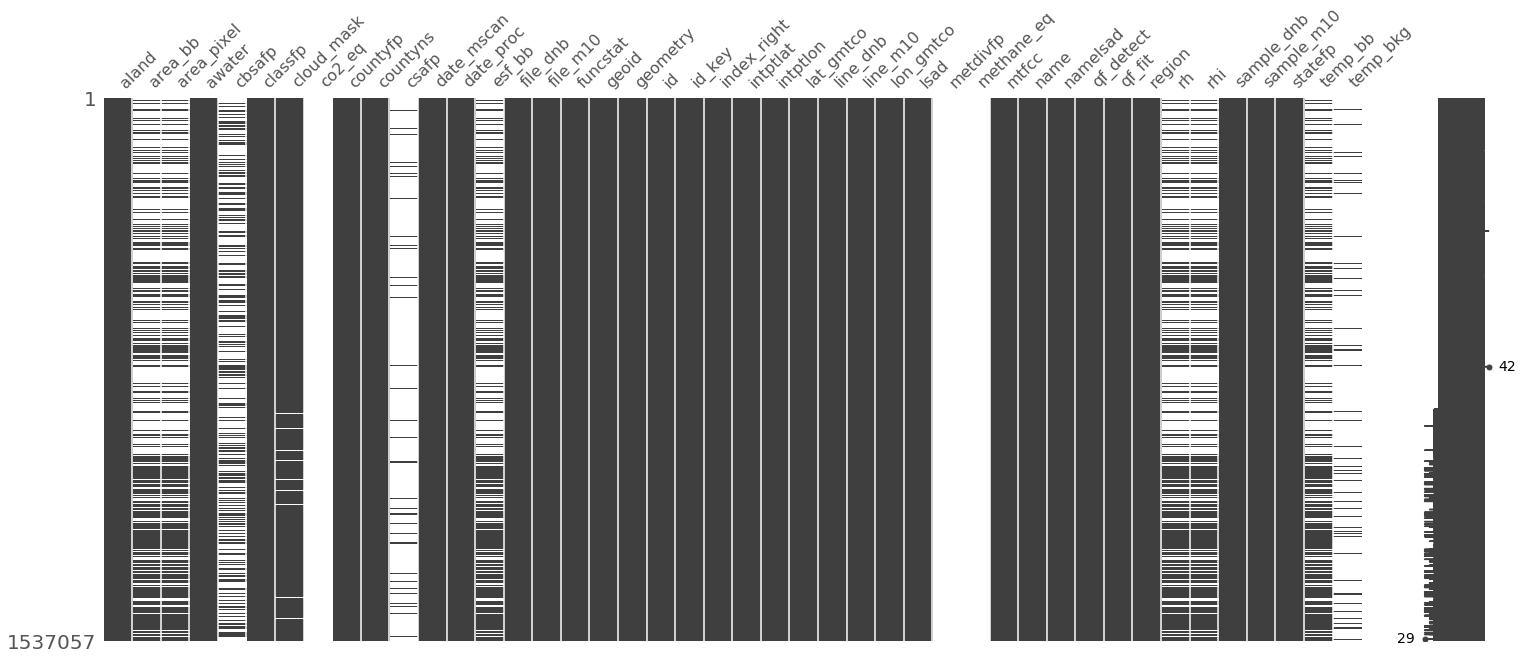

In [98]:
msno.matrix(df);  # showing NaN data.

In [99]:
df.isnull().sum()  # which columns have nulls

aland                0
area_bb         806162
area_pixel      806162
awater               0
cbsafp          973416
classfp              0
cloud_mask       36630
co2_eq         1537057
countyfp             0
countyns             0
csafp          1425190
date_mscan           0
date_proc            0
esf_bb          806162
file_dnb             0
file_m10             0
funcstat             0
geoid                0
geometry             0
id                   0
id_key               0
index_right          0
intptlat             0
intptlon             0
lat_gmtco            0
line_dnb          1120
line_m10             0
lon_gmtco            0
lsad                 0
metdivfp       1537013
methane_eq     1537057
mtfcc                0
name                 0
namelsad             0
qf_detect            0
qf_fit               0
region               0
rh              806162
rhi             806162
sample_dnb        1120
sample_m10           0
statefp              0
temp_bb         806162
temp_bkg   

In [100]:
# drop very incomplete columns and unnecessary census county columns. 
df = df.drop(
    columns=[
        'metdivfp',  # drop these b/c majority missing, not useful
        'methane_eq',
        'temp_bkg',
        'csafp',
        'co2_eq',  # drop these b/c majority missing, not useful
        'file_dnb',  # more viirs to drop
        'file_m10',  # ibid...
        'id', 
        'id_key',
        'line_dnb',
        'line_m10',
        'sample_dnb',
        'sample_m10',
        'cloud_mask',
        'date_proc',  # don't need processed date, use date_mscan
        'lat_gmtco',  # viirs lat
        'lon_gmtco',  # viirs lon
        'statefp',  # census variables not useful
        'countyfp', # ibid...
        'countyns',
        'name',
        'namelsad',
        'lsad',
        'classfp',
        'mtfcc',
        'cbsafp',
        'intptlat',
        'intptlon',
        'awater',
        'funcstat',  # census variables not useful
        'index_right',  # not useful but maybe check where this came from 
    ],
)
df.isnull().sum()  # nulls after dropping columns, this is expected

aland              0
area_bb       806162
area_pixel    806162
date_mscan         0
esf_bb        806162
geoid              0
geometry           0
qf_detect          0
qf_fit             0
region             0
rh            806162
rhi           806162
temp_bb       806162
dtype: int64

In [101]:
# reorder the variables manually 
df = df[[
    'date_mscan',
    'geometry',
    'region',
    'geoid',
    'aland',
    'qf_detect',
    'qf_fit',
    'area_bb',
    'area_pixel',
    'esf_bb',
    'rh',
    'rhi',
    'temp_bb',
]]

In [102]:
df_complete_rows = df.dropna()

In [103]:
df_complete_rows.shape  
# this is data that will be set aside and used if temperature and other data is leveraged. will discuss in results
# and discussions notebook.

(730895, 13)

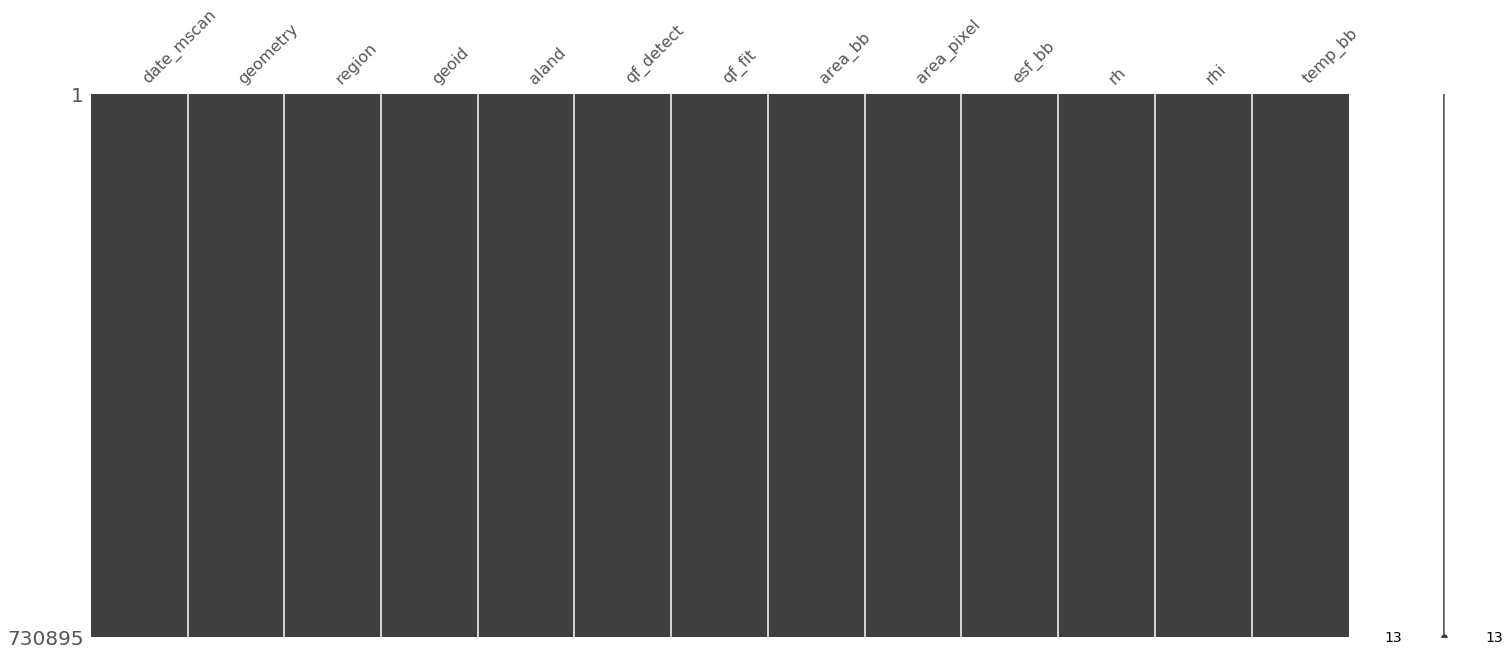

In [104]:
msno.matrix(df_complete_rows);  # showing completely filled data observations

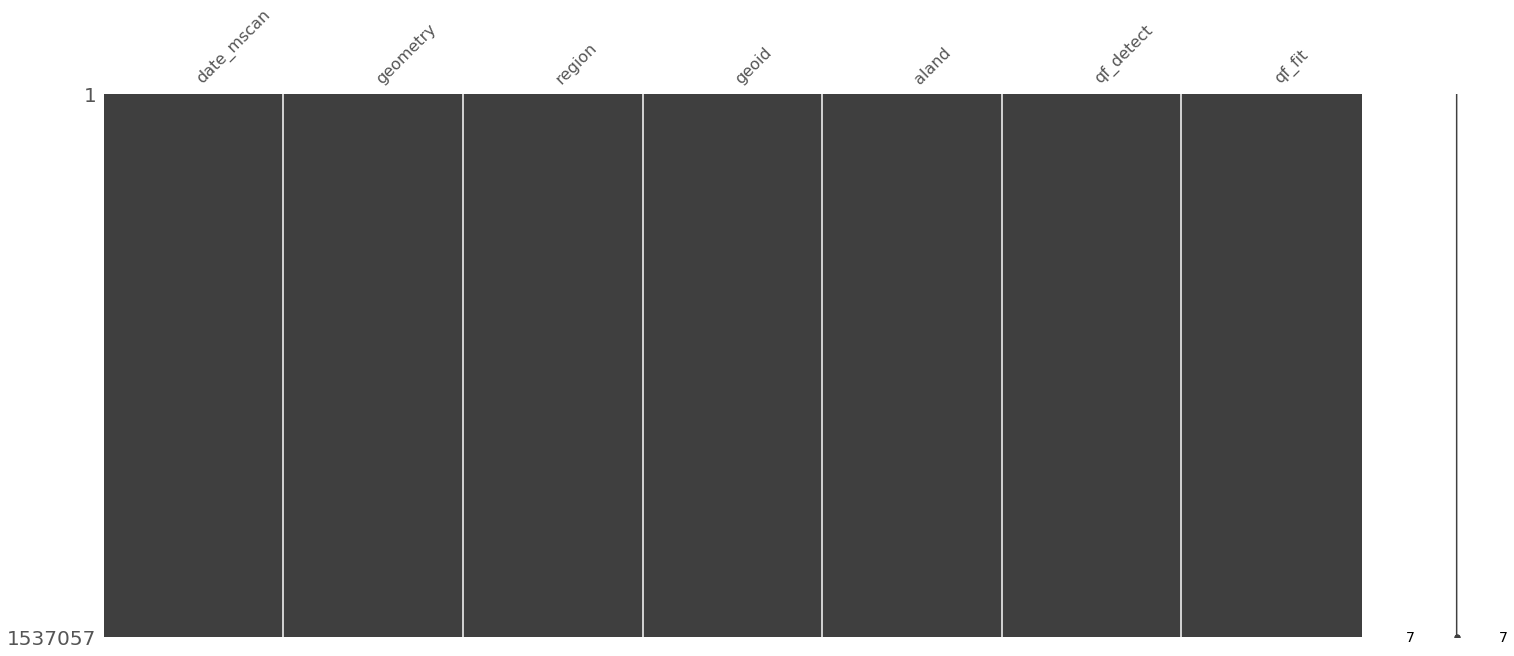

In [105]:
df = df.dropna(axis=1, how='any')
msno.matrix(df);  # df, now only has columns that are complete. 

In [106]:
df['date'] = pd.to_datetime(df['date_mscan']).dt.date

df_for_agg = df[['date', 'region', 'geoid', 'qf_detect', 'qf_fit']]
df_for_agg['geoid'].dtypes

dtype('O')

In [107]:
census_gdf['geoid'].dtypes  # check data type for geoid, make sure object

dtype('O')

In [108]:
df_for_agg

,date,region,geoid,qf_detect,qf_fit
0,2012-03-01,Bakken Region,38061,2049.0,0.0
1,2012-03-01,Bakken Region,38061,2371.0,0.0
2,2012-03-01,Bakken Region,38061,2177.0,0.0
3,2012-03-01,Bakken Region,38061,2499.0,0.0
4,2012-03-01,Bakken Region,38061,2433.0,0.0
...,...,...,...,...,...
528051,2020-03-12,Eagle Ford Region,48283,428289.0,1.0
528052,2020-03-12,Eagle Ford Region,48283,442181.0,1.0
528053,2020-03-12,Eagle Ford Region,48283,439872.0,0.0
528054,2020-03-12,Eagle Ford Region,48283,432969.0,1.0


## Aggregate data for Region by Day

In [109]:
df_for_agg['count'] = 1

df_day_agg = df_for_agg.groupby(
    ["date", "region"],
).agg(
    latest_day_in_month=pd.NamedAgg(column='date', aggfunc='max'),
    obs_day_cnt=pd.NamedAgg(column='count', aggfunc='sum'),
    qf_detect_day_avg=pd.NamedAgg(column='qf_detect', aggfunc='mean'),
    qf_detect_day_med=pd.NamedAgg(column='qf_detect', aggfunc='median'),
    qf_detect_day_sum=pd.NamedAgg(column='qf_detect', aggfunc='sum'),
    qf_detect_day_min=pd.NamedAgg(column='qf_detect', aggfunc='min'),
    qf_detect_day_max=pd.NamedAgg(column='qf_detect', aggfunc='max'),
    qf_fit_day_avg=pd.NamedAgg(column='qf_fit', aggfunc='mean'),
    qf_fit_day_med=pd.NamedAgg(column='qf_fit', aggfunc='median'),
    qf_fit_day_sum=pd.NamedAgg(column='qf_fit', aggfunc='sum'),
    qf_fit_day_min=pd.NamedAgg(column='qf_fit', aggfunc='min'),
    qf_fit_day_max=pd.NamedAgg(column='qf_fit', aggfunc='max'),
).reset_index().copy()


## Explore Aggregated data for Region by Day

In [110]:
df_day_agg.head(3)

,date,region,latest_day_in_month,obs_day_cnt,qf_detect_day_avg,qf_detect_day_med,qf_detect_day_sum,qf_detect_day_min,qf_detect_day_max,qf_fit_day_avg,qf_fit_day_med,qf_fit_day_sum,qf_fit_day_min,qf_fit_day_max
0,2012-03-01,Anadarko Region,2012-03-01,10,4309.400000,3397.0,43094.0,2049.0,16241.0,3.700000,0.0,37.0,0.0,34.0
1,2012-03-01,Appalachia Region,2012-03-01,7,8214.142857,3841.0,57499.0,2309.0,16177.0,14.714286,1.0,103.0,0.0,34.0
2,2012-03-01,Bakken Region,2012-03-01,205,4014.482927,3841.0,822969.0,2049.0,16381.0,2.365854,0.0,485.0,0.0,34.0


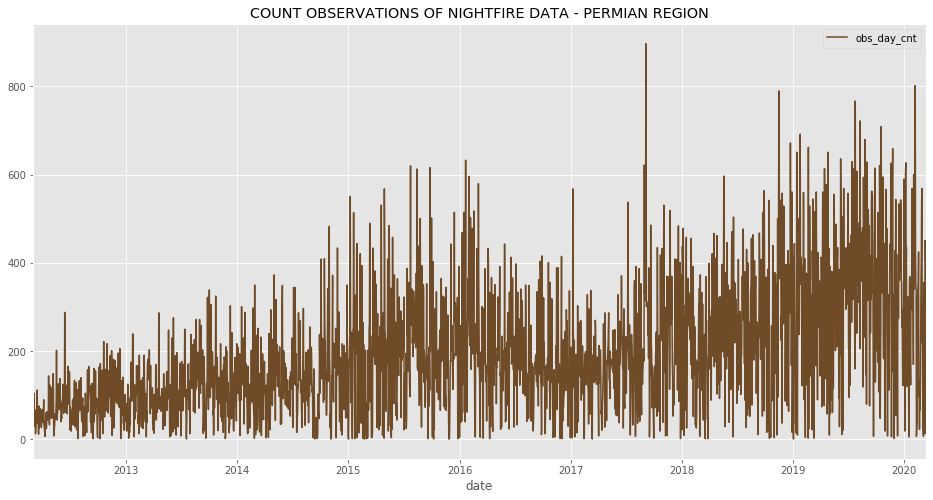

In [111]:
region = 'Permian Region'

df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['obs_day_cnt']].plot(
    label='Count of Observations of Nightfire Data',
    legend=True,
    figsize=(16, 8), 
    c=basin_colors_hex[region],
)
plt.title(f'Count Observations of Nightfire Data - {region}'.upper());

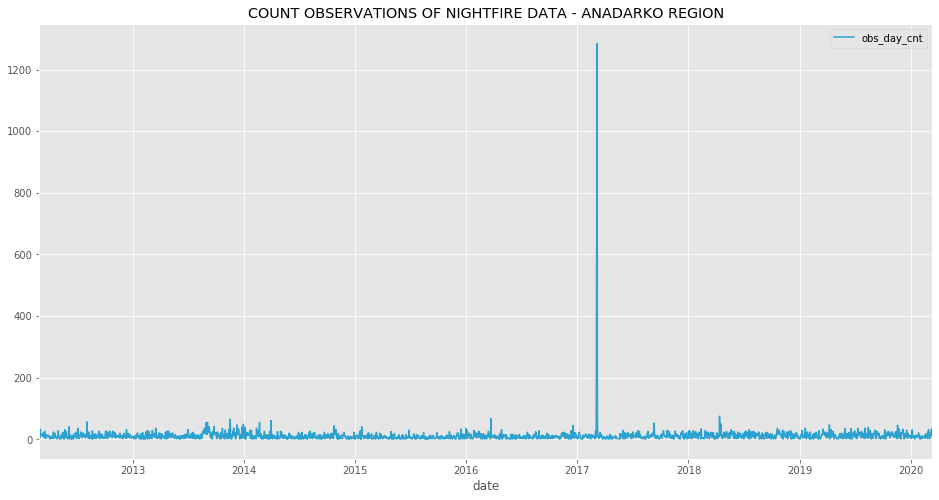

In [112]:
region = 'Anadarko Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['obs_day_cnt']].plot(
    label='Count of Observations of Nightfire Data',
    legend=True,
    figsize=(16, 8), 
    c=basin_colors_hex[region],
)
plt.title(f'Count Observations of Nightfire Data - {region}'.upper());  
# seems to be some weird event in Anadarko Region, confirmed as a possible explosion. 

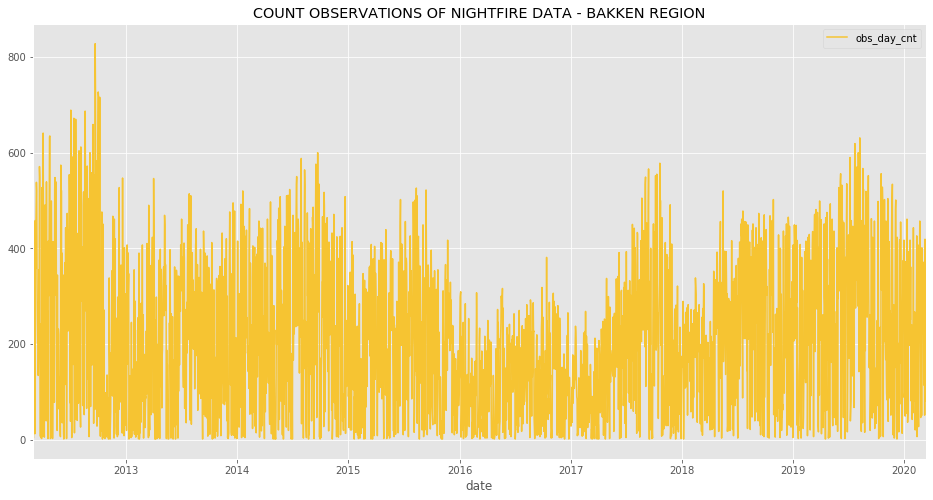

In [113]:
region = 'Bakken Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['obs_day_cnt']].plot(
    label='Count of Observations of Nightfire Data',
    legend=True,
    figsize=(16, 8), 
    c=basin_colors_hex[region],
)
plt.title(f'Count Observations of Nightfire Data - {region}'.upper());

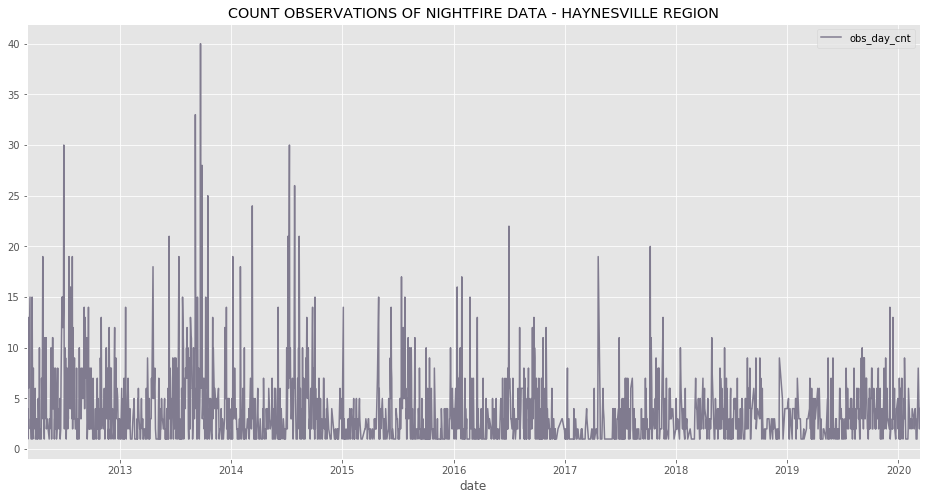

In [114]:
region = 'Haynesville Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['obs_day_cnt']].plot(
    label='Count of Observations of Nightfire Data',
    legend=True,
    figsize=(16, 8), 
    c=basin_colors_hex[region],
)
plt.title(f'Count Observations of Nightfire Data - {region}'.upper());

### Keep `obs_day_cnt`, looks reliable.  

Anadarko region has something strange, but there is a large fire in 2017. 

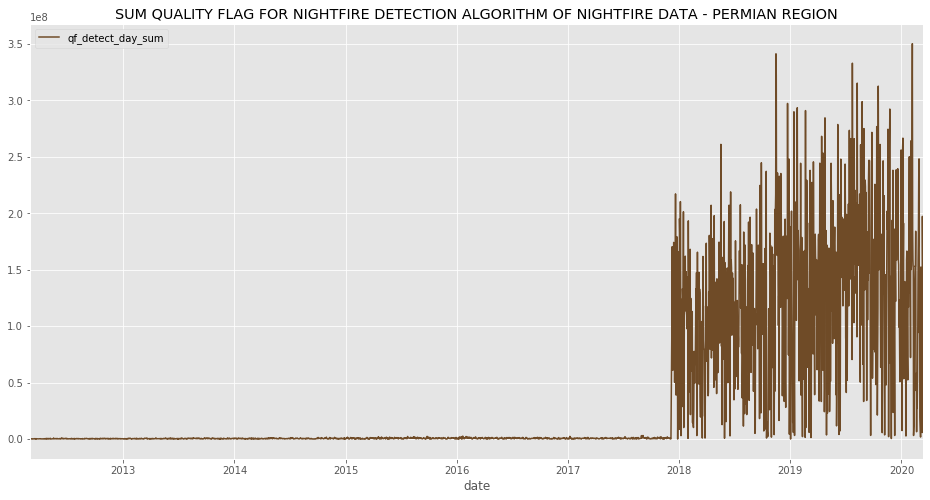

In [115]:
region = 'Permian Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['qf_detect_day_sum']].plot(
    label='Sum Quality flag for Nightfire detection algorithm',
    legend=True,
    figsize=(16, 8), 
    c=basin_colors_hex[region],
)
plt.title(f'Sum Quality flag for Nightfire detection algorithm of Nightfire Data - {region}'.upper());

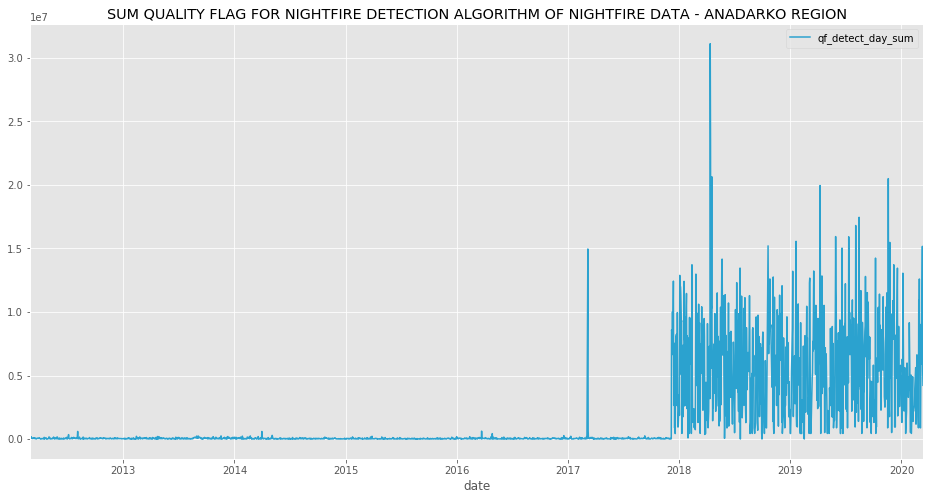

In [116]:
region = 'Anadarko Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['qf_detect_day_sum']].plot(
    label='Sum Quality flag for Nightfire detection algorithm',
    legend=True,
    figsize=(16, 8), 
    c=basin_colors_hex[region],
)
plt.title(f'Sum Quality flag for Nightfire detection algorithm of Nightfire Data - {region}'.upper());

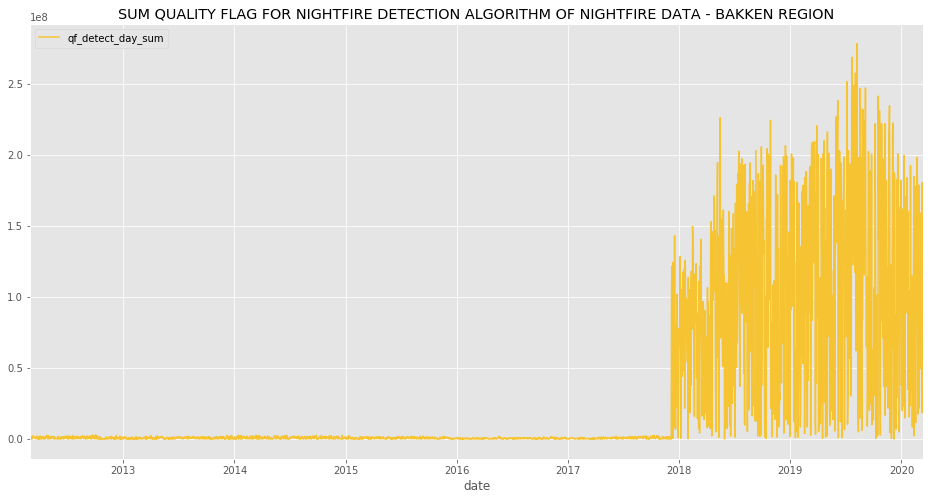

In [117]:
region = 'Bakken Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['qf_detect_day_sum']].plot(
    label='Sum Quality flag for Nightfire detection algorithm',
    legend=True,
    figsize=(16, 8), 
    c=basin_colors_hex[region],
)
plt.title(f'Sum Quality flag for Nightfire detection algorithm of Nightfire Data - {region}'.upper());

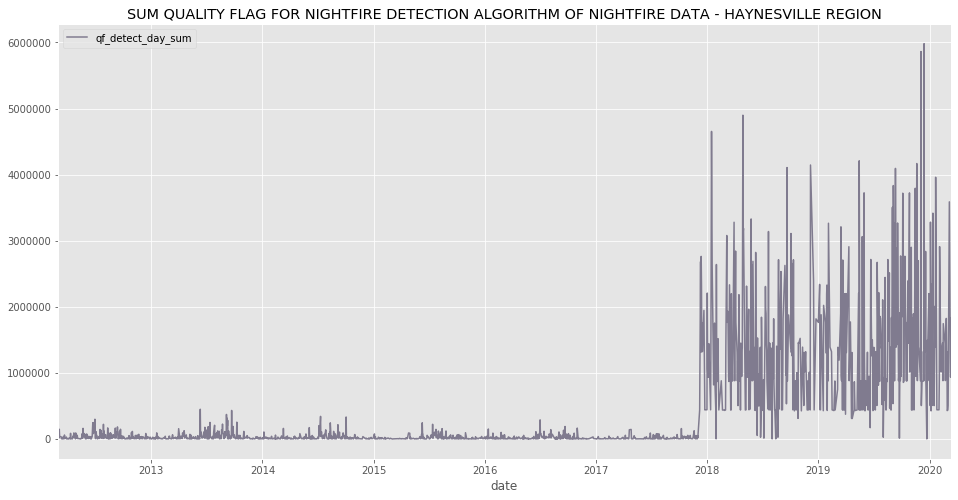

In [118]:
region = 'Haynesville Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['qf_detect_day_sum']].plot(
    label='Sum Quality flag for Nightfire detection algorithm',
    legend=True,
    figsize=(16, 8), 
    c=basin_colors_hex[region],
)
plt.title(f'Sum Quality flag for Nightfire detection algorithm of Nightfire Data - {region}'.upper());

### Drop `qf_detect` 
From the plots above, I can summize that `qf_detect` variables are systematically different from v2.1c to 3.0.

In [119]:
df_day_agg.drop(
    columns=[
        'qf_detect_day_avg',
        'qf_detect_day_med',
        'qf_detect_day_sum',
        'qf_detect_day_min',
        'qf_detect_day_max',
    ],
    inplace=True
)

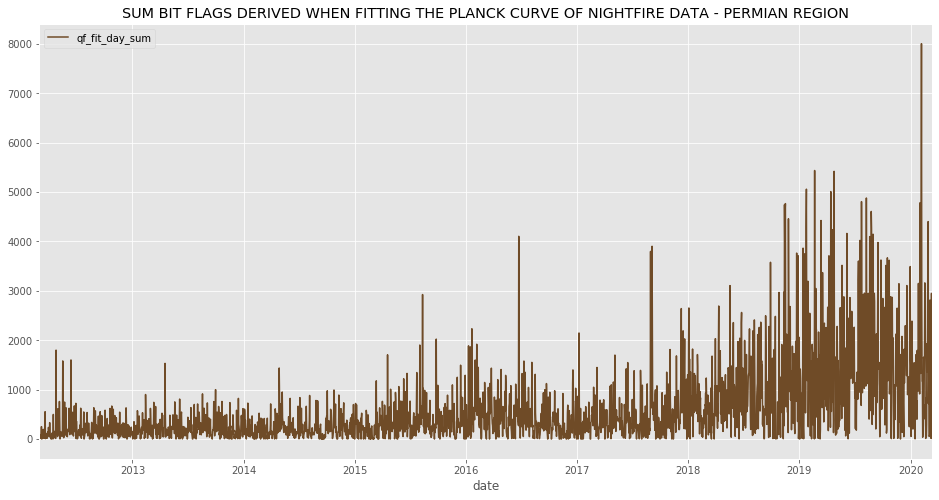

In [120]:
region = 'Permian Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['qf_fit_day_sum']].plot(
    label='bit flags derived when fitting the Planck curve Nightfire detection algorithm',
    legend=True,
    figsize=(16, 8), 
    c=basin_colors_hex[region],
)
plt.title(f'Sum bit flags derived when fitting the Planck curve of Nightfire Data - {region}'.upper());

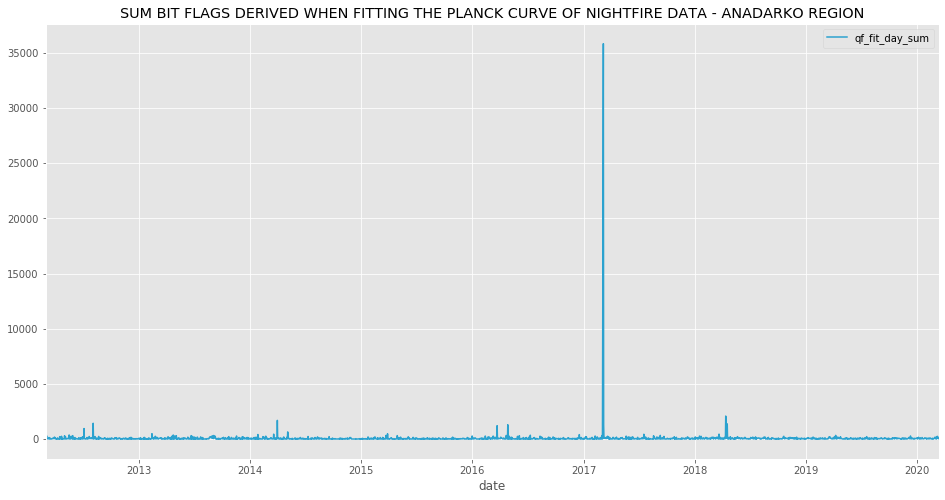

In [121]:
region = 'Anadarko Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['qf_fit_day_sum']].plot(
    label='bit flags derived when fitting the Planck curve Nightfire detection algorithm',
    legend=True,
    figsize=(16, 8), 
    c=basin_colors_hex[region],
)
plt.title(f'Sum bit flags derived when fitting the Planck curve of Nightfire Data - {region}'.upper());
# weird noise, but perhaps acceptable

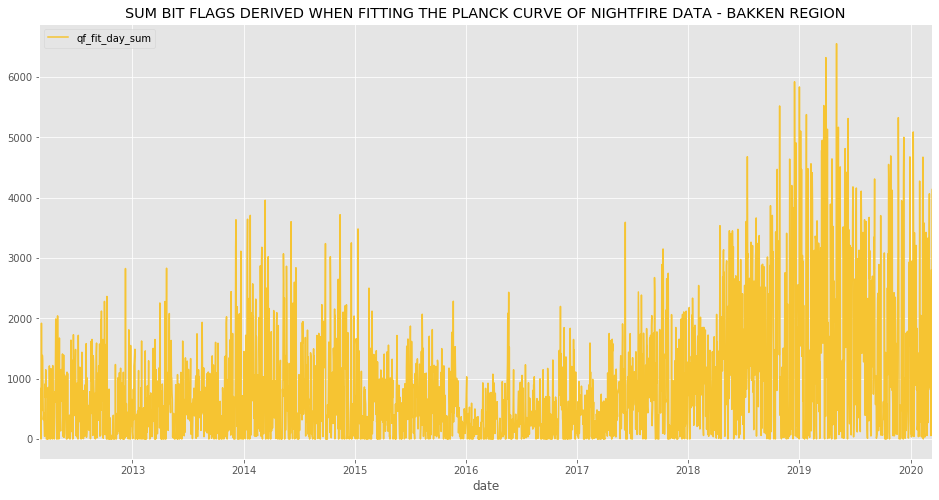

In [122]:
region = 'Bakken Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['qf_fit_day_sum']].plot(
    label='bit flags derived when fitting the Planck curve Nightfire detection algorithm',
    legend=True,
    figsize=(16, 8), 
    c=basin_colors_hex[region],
)
plt.title(f'Sum bit flags derived when fitting the Planck curve of Nightfire Data - {region}'.upper());

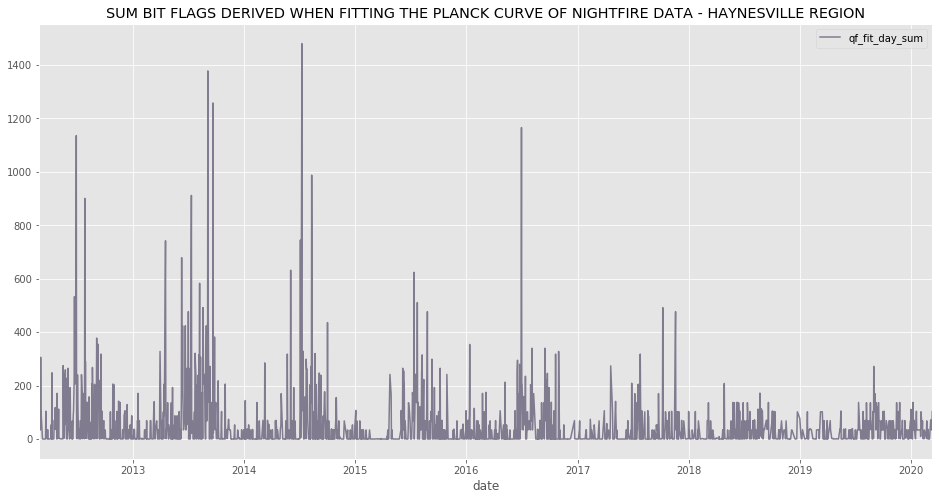

In [123]:
region = 'Haynesville Region'
df_day_agg[
    df_day_agg['region'] == region
].set_index('date')[['qf_fit_day_sum']].plot(
    label='bit flags derived when fitting the Planck curve Nightfire detection algorithm',
    legend=True,
    figsize=(16, 8), 
    c=basin_colors_hex[region],
)
plt.title(f'Sum bit flags derived when fitting the Planck curve of Nightfire Data - {region}'.upper());

### Keep `qf_fit`
The `qf_fit` variable doesn't seem to have the systematic error as `qf_detect`. 


In [124]:
df_day_agg.head(3)

,date,region,latest_day_in_month,obs_day_cnt,qf_fit_day_avg,qf_fit_day_med,qf_fit_day_sum,qf_fit_day_min,qf_fit_day_max
0,2012-03-01,Anadarko Region,2012-03-01,10,3.700000,0.0,37.0,0.0,34.0
1,2012-03-01,Appalachia Region,2012-03-01,7,14.714286,1.0,103.0,0.0,34.0
2,2012-03-01,Bakken Region,2012-03-01,205,2.365854,0.0,485.0,0.0,34.0


## Create Monthly Aggregation Decriptive Statistics of Daily variables

In [125]:
df_day_agg['year_month'] = pd.to_datetime(
    df_day_agg['date'].apply(lambda x: x.strftime('%Y-%m'))
)  # create year_month column

df_day_agg

,date,region,latest_day_in_month,obs_day_cnt,qf_fit_day_avg,qf_fit_day_med,qf_fit_day_sum,qf_fit_day_min,qf_fit_day_max,year_month
0,2012-03-01,Anadarko Region,2012-03-01,10,3.700000,0.0,37.0,0.0,34.0,2012-03-01
1,2012-03-01,Appalachia Region,2012-03-01,7,14.714286,1.0,103.0,0.0,34.0,2012-03-01
2,2012-03-01,Bakken Region,2012-03-01,205,2.365854,0.0,485.0,0.0,34.0,2012-03-01
3,2012-03-01,Eagle Ford Region,2012-03-01,31,0.322581,0.0,10.0,0.0,1.0,2012-03-01
4,2012-03-01,Haynesville Region,2012-03-01,1,34.000000,34.0,34.0,34.0,34.0,2012-03-01
...,...,...,...,...,...,...,...,...,...,...
18464,2020-03-12,Appalachia Region,2020-03-12,3,11.666667,1.0,35.0,0.0,34.0,2020-03-01
18465,2020-03-12,Bakken Region,2020-03-12,376,10.997340,1.0,4135.0,0.0,42.0,2020-03-01
18466,2020-03-12,Eagle Ford Region,2020-03-12,74,0.851351,1.0,63.0,0.0,9.0,2020-03-01
18467,2020-03-12,Niobrara Region,2020-03-12,4,9.000000,1.0,36.0,0.0,34.0,2020-03-01


In [126]:
df_month_agg = df_day_agg.groupby(
    ["year_month", "region"],
).agg(
    latest_day_in_month=pd.NamedAgg(column='date', aggfunc='max'),
    
    obs_day_cnt_avg=pd.NamedAgg(column='obs_day_cnt', aggfunc='mean'),
    obs_day_cnt_med=pd.NamedAgg(column='obs_day_cnt', aggfunc='median'),
    obs_day_cnt_sum=pd.NamedAgg(column='obs_day_cnt', aggfunc='sum'),
    obs_day_cnt_min=pd.NamedAgg(column='obs_day_cnt', aggfunc='min'),
    obs_day_cnt_max=pd.NamedAgg(column='obs_day_cnt', aggfunc='max'),
    
    qf_fit_day_avg_avg=pd.NamedAgg(column='qf_fit_day_avg', aggfunc='mean'),
    qf_fit_day_avg_med=pd.NamedAgg(column='qf_fit_day_avg', aggfunc='median'),
    qf_fit_day_avg_sum=pd.NamedAgg(column='qf_fit_day_avg', aggfunc='sum'),
    qf_fit_day_avg_min=pd.NamedAgg(column='qf_fit_day_avg', aggfunc='min'),
    qf_fit_day_avg_max=pd.NamedAgg(column='qf_fit_day_avg', aggfunc='max'),

    qf_fit_day_med_avg=pd.NamedAgg(column='qf_fit_day_med', aggfunc='mean'),
    qf_fit_day_med_med=pd.NamedAgg(column='qf_fit_day_med', aggfunc='median'),
    qf_fit_day_med_sum=pd.NamedAgg(column='qf_fit_day_med', aggfunc='sum'),
    qf_fit_day_med_min=pd.NamedAgg(column='qf_fit_day_med', aggfunc='min'),
    qf_fit_day_med_max=pd.NamedAgg(column='qf_fit_day_med', aggfunc='max'),
    
    qf_fit_day_sum_avg=pd.NamedAgg(column='qf_fit_day_sum', aggfunc='mean'),
    qf_fit_day_sum_med=pd.NamedAgg(column='qf_fit_day_sum', aggfunc='median'),
    qf_fit_day_sum_sum=pd.NamedAgg(column='qf_fit_day_sum', aggfunc='sum'),
    qf_fit_day_sum_min=pd.NamedAgg(column='qf_fit_day_sum', aggfunc='min'),
    qf_fit_day_sum_max=pd.NamedAgg(column='qf_fit_day_sum', aggfunc='max'),
  
    qf_fit_day_min_avg=pd.NamedAgg(column='qf_fit_day_min', aggfunc='mean'),
    qf_fit_day_min_med=pd.NamedAgg(column='qf_fit_day_min', aggfunc='median'),
    qf_fit_day_min_sum=pd.NamedAgg(column='qf_fit_day_min', aggfunc='sum'),
    qf_fit_day_min_min=pd.NamedAgg(column='qf_fit_day_min', aggfunc='min'),
    qf_fit_day_min_max=pd.NamedAgg(column='qf_fit_day_min', aggfunc='max'),
       
    qf_fit_day_max_avg=pd.NamedAgg(column='qf_fit_day_max', aggfunc='mean'),
    qf_fit_day_max_med=pd.NamedAgg(column='qf_fit_day_max', aggfunc='median'),
    qf_fit_day_max_sum=pd.NamedAgg(column='qf_fit_day_max', aggfunc='sum'),
    qf_fit_day_max_min=pd.NamedAgg(column='qf_fit_day_max', aggfunc='min'),
    qf_fit_day_max_max=pd.NamedAgg(column='qf_fit_day_max', aggfunc='max'),
).reset_index().copy()

## Explore Monthly Aggregation Decriptive Statistics of Daily variables

In [127]:
df_month_agg

,year_month,region,latest_day_in_month,obs_day_cnt_avg,obs_day_cnt_med,obs_day_cnt_sum,obs_day_cnt_min,obs_day_cnt_max,qf_fit_day_avg_avg,qf_fit_day_avg_med,...,qf_fit_day_min_avg,qf_fit_day_min_med,qf_fit_day_min_sum,qf_fit_day_min_min,qf_fit_day_min_max,qf_fit_day_max_avg,qf_fit_day_max_med,qf_fit_day_max_sum,qf_fit_day_max_min,qf_fit_day_max_max
0,2012-03-01,Anadarko Region,2012-03-31,13.041667,12.5,313,3,33,4.786164,4.291667,...,0.000000,0.0,0.0,0.0,0.0,31.583333,34.0,758.0,0.0,53.0
1,2012-03-01,Appalachia Region,2012-03-31,31.071429,32.0,870,1,86,9.502222,8.966184,...,0.000000,0.0,0.0,0.0,0.0,37.000000,34.0,1036.0,0.0,53.0
2,2012-03-01,Bakken Region,2012-03-31,260.321429,249.0,7289,2,571,1.497039,1.500962,...,0.000000,0.0,0.0,0.0,0.0,26.642857,34.0,746.0,0.0,53.0
3,2012-03-01,Eagle Ford Region,2012-03-31,48.538462,30.0,1262,1,209,1.046799,0.374157,...,0.000000,0.0,0.0,0.0,0.0,13.307692,1.0,346.0,0.0,53.0
4,2012-03-01,Haynesville Region,2012-03-31,4.476190,2.0,94,1,15,8.188339,0.000000,...,3.285714,0.0,69.0,0.0,34.0,15.523810,0.0,326.0,0.0,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,2020-03-01,Bakken Region,2020-03-12,241.833333,233.0,2902,51,419,6.892895,6.807222,...,0.000000,0.0,0.0,0.0,0.0,33.250000,34.0,399.0,9.0,42.0
675,2020-03-01,Eagle Ford Region,2020-03-12,53.250000,40.0,639,1,172,1.606405,0.925676,...,0.083333,0.0,1.0,0.0,1.0,16.000000,9.0,192.0,0.0,34.0
676,2020-03-01,Haynesville Region,2020-03-11,3.166667,2.5,19,1,8,10.597222,10.166667,...,0.333333,0.0,2.0,0.0,1.0,22.666667,34.0,136.0,0.0,34.0
677,2020-03-01,Niobrara Region,2020-03-12,12.916667,12.5,155,4,28,5.332056,5.119048,...,0.000000,0.0,0.0,0.0,0.0,29.166667,34.0,350.0,1.0,34.0


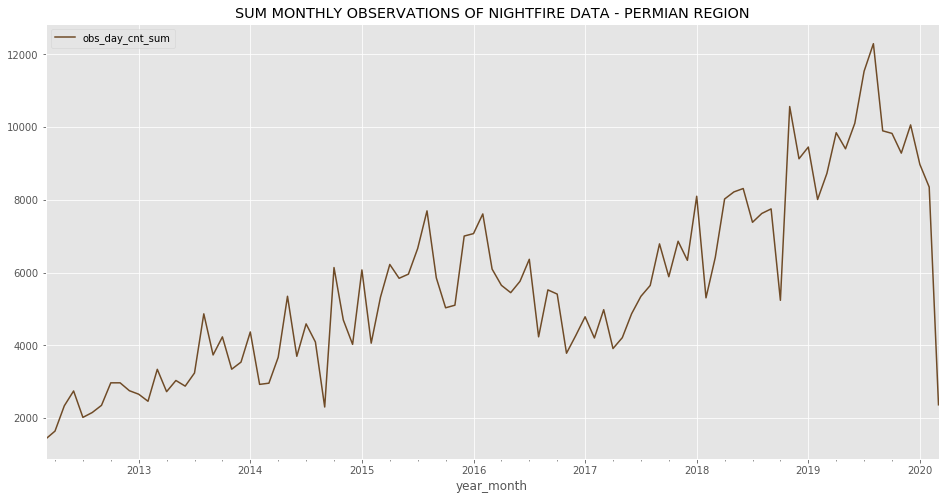

In [128]:
region = 'Permian Region'
df_month_agg[
    df_month_agg['region'] == region
].set_index('year_month')[['obs_day_cnt_sum']].plot(
    figsize=(16, 8), 
    c=basin_colors_hex[region],
);  # expected dropoff, march is not complete for sum
plt.title(f'Sum Monthly Observations of Nightfire Data - {region}'.upper());

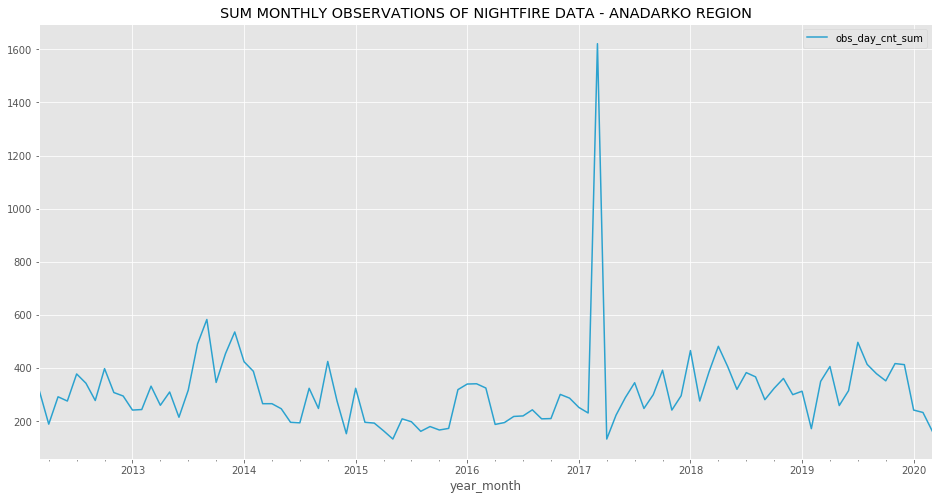

In [129]:
region = 'Anadarko Region'
df_month_agg[
    df_month_agg['region'] == region
].set_index('year_month')[['obs_day_cnt_sum']].plot(
    figsize=(16, 8),
    c=basin_colors_hex[region],
);  
plt.title(f'Sum Monthly Observations of Nightfire Data - {region}'.upper());  # expected dropoff, march is not complete for sum

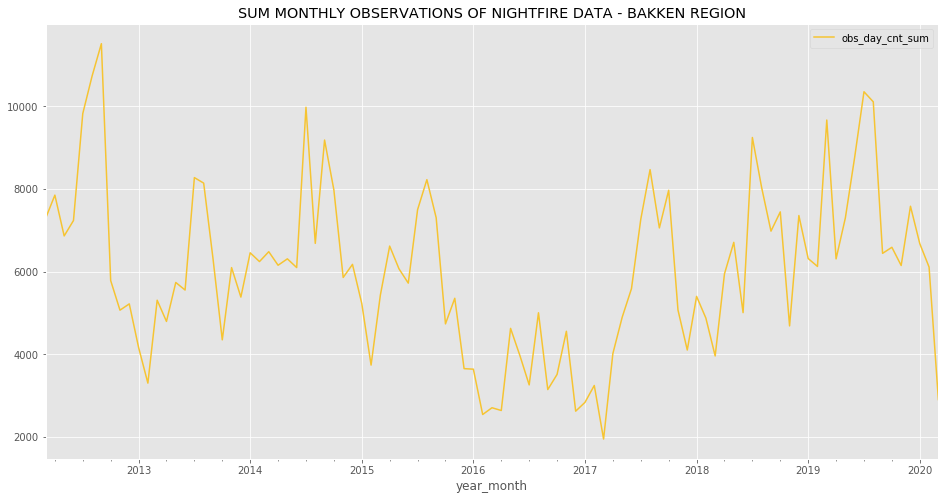

In [130]:
region = 'Bakken Region'
df_month_agg[
    df_month_agg['region'] == region
].set_index('year_month')[['obs_day_cnt_sum']].plot(
    figsize=(16, 8),
    c=basin_colors_hex[region],
);  # expected dropoff, march is not complete for sum
plt.title(f'Sum Monthly Observations of Nightfire Data - {region}'.upper());

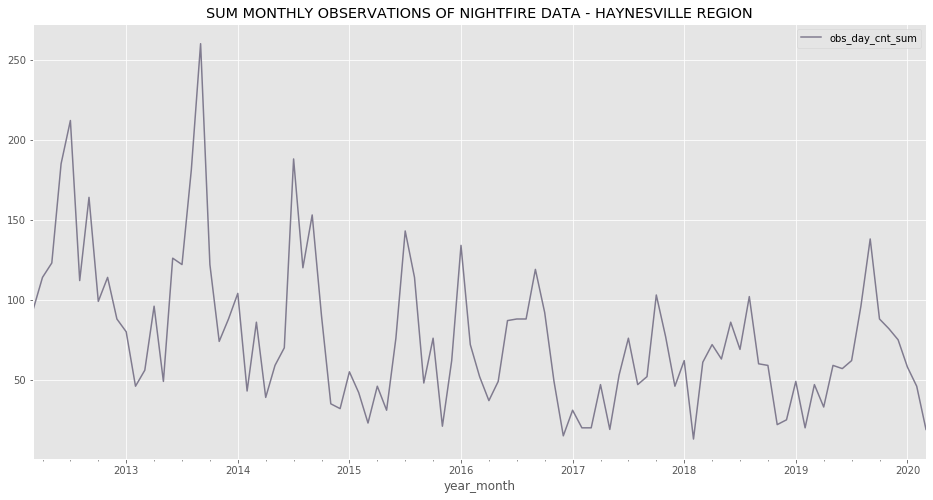

In [131]:
region = 'Haynesville Region'
df_month_agg[
    df_month_agg['region'] == region
].set_index('year_month')[['obs_day_cnt_sum']].plot(
    figsize=(16, 8),
    c=basin_colors_hex[region],
);  # expected dropoff, march is not complete for sum
plt.title(f'Sum Monthly Observations of Nightfire Data - {region}'.upper());

In [132]:
df_month_agg.shape  # check shape

(679, 33)

In [133]:
df_month_agg.shape[0] / 7. 
# number of months of data for each of the seven regions. 

97.0

In [134]:
all_basins[['region', 'geoid', 'aland']].head(6)
# next, create variable of total land area in square meters for basin
# geoid's are unique counties and aland is their land area

,region,geoid,aland
0,Permian Region,48327,2336237920
1,Permian Region,48189,2602109431
2,Appalachia Region,42007,1125901161
3,Appalachia Region,54075,2435322222
4,Haynesville Region,22111,2271359845
5,Appalachia Region,36101,3601504767


In [135]:
basin_area = all_basins[['region', 'aland']].groupby(
    ['region'],
    as_index=False,
).sum()  # calculate the total land area of the unique regions by square meters. this is sum of county land area. 

basin_area

,region,aland
0,Anadarko Region,75463801085
1,Appalachia Region,192181893591
2,Bakken Region,91261078507
3,Eagle Ford Region,64571223163
4,Haynesville Region,48802443064
5,Niobrara Region,232124086468
6,Permian Region,211875565064


In [136]:
df_month_agg = df_month_agg.merge(basin_area, on='region', how='left')

df_month_agg  # inspect the viirs data aggregations and join aland variable for size of area of basin

,year_month,region,latest_day_in_month,obs_day_cnt_avg,obs_day_cnt_med,obs_day_cnt_sum,obs_day_cnt_min,obs_day_cnt_max,qf_fit_day_avg_avg,qf_fit_day_avg_med,...,qf_fit_day_min_med,qf_fit_day_min_sum,qf_fit_day_min_min,qf_fit_day_min_max,qf_fit_day_max_avg,qf_fit_day_max_med,qf_fit_day_max_sum,qf_fit_day_max_min,qf_fit_day_max_max,aland
0,2012-03-01,Anadarko Region,2012-03-31,13.041667,12.5,313,3,33,4.786164,4.291667,...,0.0,0.0,0.0,0.0,31.583333,34.0,758.0,0.0,53.0,75463801085
1,2012-03-01,Appalachia Region,2012-03-31,31.071429,32.0,870,1,86,9.502222,8.966184,...,0.0,0.0,0.0,0.0,37.000000,34.0,1036.0,0.0,53.0,192181893591
2,2012-03-01,Bakken Region,2012-03-31,260.321429,249.0,7289,2,571,1.497039,1.500962,...,0.0,0.0,0.0,0.0,26.642857,34.0,746.0,0.0,53.0,91261078507
3,2012-03-01,Eagle Ford Region,2012-03-31,48.538462,30.0,1262,1,209,1.046799,0.374157,...,0.0,0.0,0.0,0.0,13.307692,1.0,346.0,0.0,53.0,64571223163
4,2012-03-01,Haynesville Region,2012-03-31,4.476190,2.0,94,1,15,8.188339,0.000000,...,0.0,69.0,0.0,34.0,15.523810,0.0,326.0,0.0,53.0,48802443064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,2020-03-01,Bakken Region,2020-03-12,241.833333,233.0,2902,51,419,6.892895,6.807222,...,0.0,0.0,0.0,0.0,33.250000,34.0,399.0,9.0,42.0,91261078507
675,2020-03-01,Eagle Ford Region,2020-03-12,53.250000,40.0,639,1,172,1.606405,0.925676,...,0.0,1.0,0.0,1.0,16.000000,9.0,192.0,0.0,34.0,64571223163
676,2020-03-01,Haynesville Region,2020-03-11,3.166667,2.5,19,1,8,10.597222,10.166667,...,0.0,2.0,0.0,1.0,22.666667,34.0,136.0,0.0,34.0,48802443064
677,2020-03-01,Niobrara Region,2020-03-12,12.916667,12.5,155,4,28,5.332056,5.119048,...,0.0,0.0,0.0,0.0,29.166667,34.0,350.0,1.0,34.0,232124086468


In [137]:
df_month_agg[['year_month', 'region', 'obs_day_cnt_sum', 'aland']]
# looks good. 

,year_month,region,obs_day_cnt_sum,aland
0,2012-03-01,Anadarko Region,313,75463801085
1,2012-03-01,Appalachia Region,870,192181893591
2,2012-03-01,Bakken Region,7289,91261078507
3,2012-03-01,Eagle Ford Region,1262,64571223163
4,2012-03-01,Haynesville Region,94,48802443064
...,...,...,...,...
674,2020-03-01,Bakken Region,2902,91261078507
675,2020-03-01,Eagle Ford Region,639,64571223163
676,2020-03-01,Haynesville Region,19,48802443064
677,2020-03-01,Niobrara Region,155,232124086468


In [138]:
for i in df_month_agg.columns:
    if (i != 'year_month') & (i != 'region') & (i != 'aland') & (i != 'latest_day_in_month'):
        df_month_agg[f'{i}_per_squaremeters'] = df_month_agg[i] / df_month_agg['aland']
# create density variables by square meter, feature engineering

### Merge the Target variable from Energy Information Administration `oil_bbl_d_total_production`

In [139]:
df_modeling = pd.merge(
    df_month_agg,
    eia_data[['month', 'region', 'oil_bbl_d_total_production']],
    left_on=['year_month', 'region'],
    right_on=['month', 'region'],
)  

### Create time dependent variables, such as percent of month completed

In [140]:
df_modeling['year'] = pd.DatetimeIndex(df_modeling['year_month']).year  # create year column
df_modeling['month'] = pd.DatetimeIndex(df_modeling['year_month']).month  # create month column

In [141]:
df_modeling['epochtime'] = (pd.to_datetime(df_modeling['year_month']) - dt.datetime(1970,1,1)).dt.total_seconds()
df_modeling['last_day_of_month'] = df_modeling['year_month'] + MonthEnd(1)
df_modeling['first_day_of_month'] = df_modeling['year_month'] + MonthBegin(0)

df_modeling['last_day_of_month_epochtime'] = (pd.to_datetime(df_modeling['last_day_of_month']) - dt.datetime(1970,1,1)).dt.total_seconds()
df_modeling['first_day_of_month_epochtime'] = (pd.to_datetime(df_modeling['first_day_of_month']) - dt.datetime(1970,1,1)).dt.total_seconds()
df_modeling['latest_day_in_month_epochtime'] = (pd.to_datetime(df_modeling['latest_day_in_month']) - dt.datetime(1970,1,1)).dt.total_seconds()

df_modeling['pct_month_completed'] = (
    df_modeling['latest_day_in_month_epochtime'] - df_modeling['first_day_of_month_epochtime']
) / (df_modeling['last_day_of_month_epochtime'] - df_modeling['first_day_of_month_epochtime'])

for i in df_modeling.columns:  # create pct month completed vars for day cnt like vars
    if i.startswith('obs_day_cnt'):
        df_modeling[f'{i}_over_pct_month_completed'] = df_modeling[i] / df_modeling['pct_month_completed']

df_modeling.head(5)  # create epochtime variables

,year_month,region,latest_day_in_month,obs_day_cnt_avg,obs_day_cnt_med,obs_day_cnt_sum,obs_day_cnt_min,obs_day_cnt_max,qf_fit_day_avg_avg,qf_fit_day_avg_med,...,obs_day_cnt_avg_over_pct_month_completed,obs_day_cnt_med_over_pct_month_completed,obs_day_cnt_sum_over_pct_month_completed,obs_day_cnt_min_over_pct_month_completed,obs_day_cnt_max_over_pct_month_completed,obs_day_cnt_avg_per_squaremeters_over_pct_month_completed,obs_day_cnt_med_per_squaremeters_over_pct_month_completed,obs_day_cnt_sum_per_squaremeters_over_pct_month_completed,obs_day_cnt_min_per_squaremeters_over_pct_month_completed,obs_day_cnt_max_per_squaremeters_over_pct_month_completed
0,2012-03-01,Anadarko Region,2012-03-31,13.041667,12.5,313,3,33,4.786164,4.291667,...,13.041667,12.5,313.0,3.0,33.0,1.728202e-10,1.656423e-10,4.147684e-09,3.975416e-11,4.372958e-10
1,2012-03-01,Appalachia Region,2012-03-31,31.071429,32.0,870,1,86,9.502222,8.966184,...,31.071429,32.0,870.0,1.0,86.0,1.616772e-10,1.665089e-10,4.526961e-09,5.203404e-12,4.474927e-10
2,2012-03-01,Bakken Region,2012-03-31,260.321429,249.0,7289,2,571,1.497039,1.500962,...,260.321429,249.0,7289.0,2.0,571.0,2.852491e-09,2.728436e-09,7.986976e-08,2.191515e-11,6.256775e-09
3,2012-03-01,Eagle Ford Region,2012-03-31,48.538462,30.0,1262,1,209,1.046799,0.374157,...,48.538462,30.0,1262.0,1.0,209.0,7.517042e-10,4.646032e-10,1.954431e-08,1.548677e-11,3.236736e-09
4,2012-03-01,Haynesville Region,2012-03-31,4.476190,2.0,94,1,15,8.188339,0.000000,...,4.476190,2.0,94.0,1.0,15.0,9.172062e-11,4.098155e-11,1.926133e-09,2.049078e-11,3.073617e-10


## Generate modeling dataset

In [142]:
df_modeling.to_csv(f"{wd}/processing/basin_int_viirs_for_modeling.csv", index=False)
# this is the dataset to use for modeling. 

### Review and sanity check a couple variables

In [143]:
df['date'] = pd.to_datetime(df['date_mscan']).dt.date

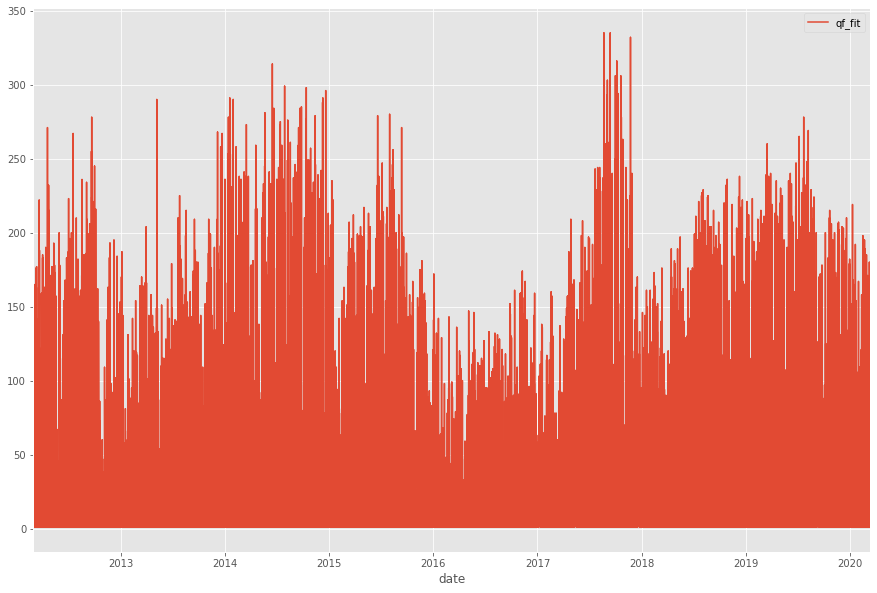

In [144]:
df[df['region'] == 'Bakken Region'].groupby(
    ['date', 'geoid'], 
    as_index=False,
).count().set_index('date')['qf_fit'].plot(figsize=(15, 10), legend=True);
# take a look at the qf_fit data

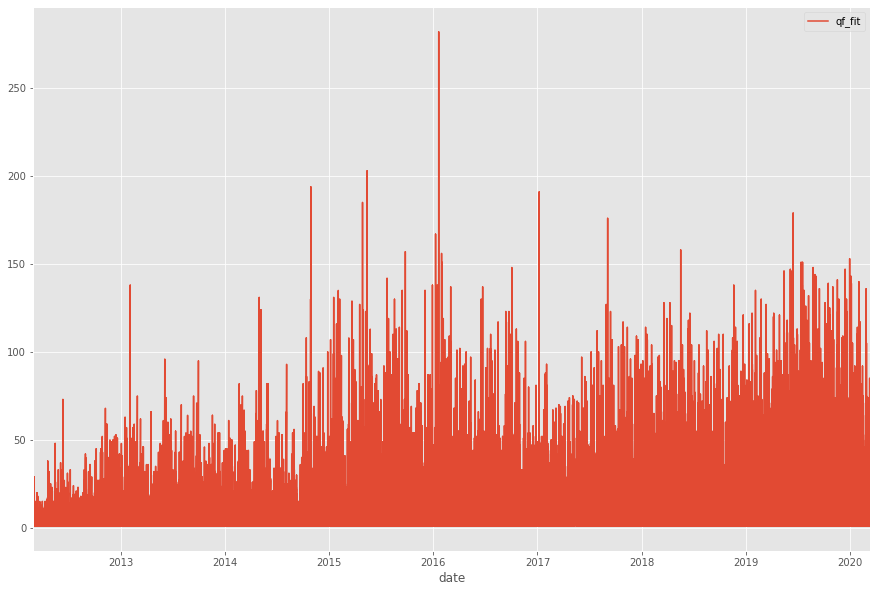

In [145]:
df[df['region'] == 'Permian Region'].groupby(
    ['date', 'geoid'], 
    as_index=False,
).count().set_index('date')['qf_fit'].plot(figsize=(15, 10), legend=True);

# Create Time Map Animation of Nightfire data in Region

In [146]:
#dfi = df.copy() 
#dfi = dfi[(df.index < '2015-1-1')]
dfi = df.copy()
print(dfi.shape)

dfi = dfi[dfi['date'].between(dt.date(2017,1,1), dt.date(2017,12,31), inclusive=True)]
dfi = dfi.set_index('date')
print(dfi.shape)

dfi = dfi[dfi['region'] == 'Bakken Region']
print(dfi.shape)


(1537057, 8)
(164209, 7)
(62465, 7)


In [147]:
dfi['geometry'] = dfi['geometry'].apply(wkt.loads)
dfig = gpd.GeoDataFrame(dfi, geometry = 'geometry')
dfig.crs = {'init' :'epsg:4326'}

In [148]:
basin_gdf = gpd.read_file(f"{wd}/input/basins/bakken_region.shp")
counties_gdf = gpd.read_file(f"{wd}/input/basins/bakken_region_counties_select.shp")

dfig = dfig.to_crs(epsg=3857)
basin_gdf = basin_gdf.to_crs(epsg=3857)
counties_gdf = counties_gdf.to_crs(epsg=3857)

In [149]:
# generate time-series 
def plot_time_geo_df(geo_df, background_df, counties, select_time):
    # inspired by https://ndres.me/post/matplotlib-animated-gifs-easily/
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    geo_df_sel = geo_df[geo_df.index == select_time]

    ax.set_facecolor('lightgrey')
    
    background_df.plot(
        ax=ax, 
        label='Bakken Region',
        legend=True,
        color=basin_colors_hex['Bakken Region'], 
        edgecolor='white', 
        linewidth=0.2, 
    ) 
    
    counties.geometry.boundary.plot(
        ax=ax,
        color=None, 
        edgecolor='white', 
        linewidth=0.3,
    )
    
    minx, miny, maxx, maxy = background_df.geometry.total_bounds
    geo_df_sel.plot(ax=ax, color='red', edgecolor='black', legend=True)
    
    ax.set_xlim(minx, maxx) 
    ax.set_ylim(miny, maxy)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_title(f'Bakken Region Nightfire (VIIRS) - {select_time}')

    plt.grid(b=None)  # get rid of grid in background if ggplot

    fig.tight_layout()
    fig.canvas.draw() 
    
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image


The above code generates this time-series animation in the Exploratory Data Analysis notebook and for the Presentation. The code below this generates the animated git. 

### A Year (2017) of Nightfire data - Bakken Region

![](../images/bakken_nightfire_2017.gif)

#### Below cell `code` generates 365 images for automated-gif animation. No need to scroll. Go to:


In [151]:
imageio.mimsave(
    '../images/bakken_nightfire_2017.gif', 
    [plot_time_geo_df(dfig, basin_gdf, counties_gdf, i) for i in dfig.index.unique()], 
    fps=12,
)  # be careful running this cell, a ton of output and takes a long time to run, comment out. 

# Next Notebook

[Modeling using Regression](https://git.generalassemb.ly/danielmartinsheehan/capstone/blob/master/notebooks/05_modeling_regression.ipynb)